In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Poisson + binomial

Characterize the error of cov/var/eta/s estimation

## Generate data

In [9]:
def simulate(s, n_cells, lam, seed=0):
    np.random.seed(seed)
    c = np.random.gamma(shape=1/s,scale=s,size=n_cells)
    X = np.random.poisson(lam=c[:,None]*lam[None,:])
    return c, X

## Get mean from K562 RNA

In [3]:
datadir = '/home/mffang/data/counts/Klein_2015/pure/'

In [4]:
pure = ad.read(datadir + 'counts_unfiltered/adata.h5ad')
pure

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 139957 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

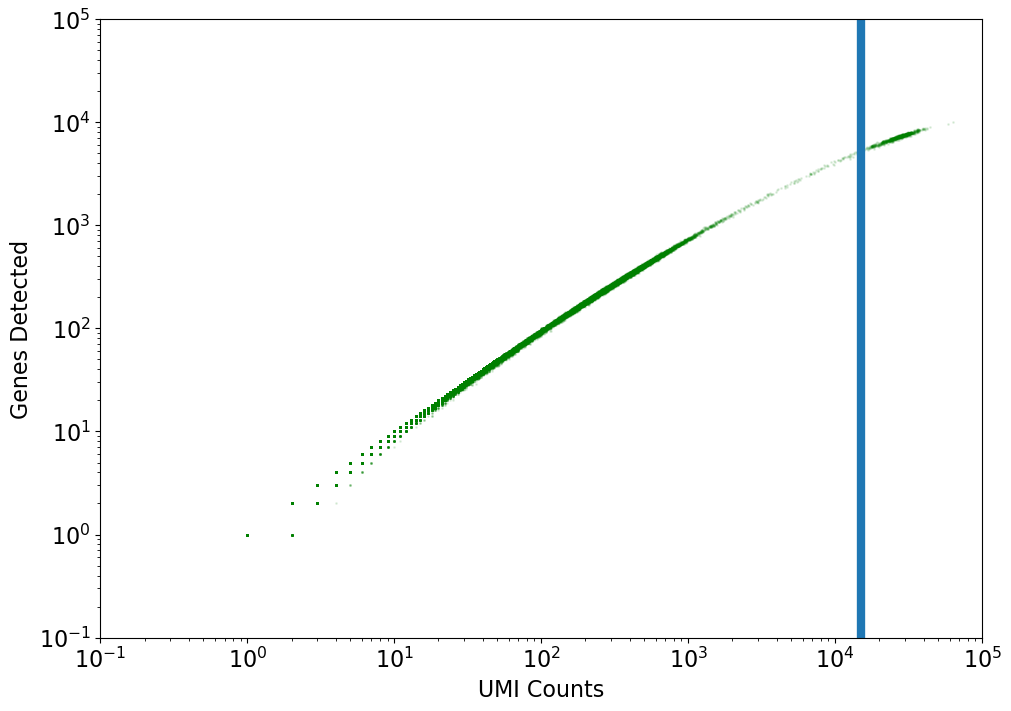

In [5]:
rna = pure.copy()

mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.1)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((0.1,100000))
ax.set_ylim((0.1,100000))
ax.axvline(x=15000)
plt.show()

In [6]:
pure = rna[np.asarray(mtx.sum(axis=1))>15000]
pure

View of AnnData object with n_obs × n_vars = 916 × 39675
    layers: 'ambiguous', 'mature', 'nascent'

## Normalized covariance

In [8]:
def estimate_s(N1, N2=None, plot=True, ax=None, min_mean=0.1, max_mean=np.inf, 
               bins=np.arange(-0.5, 1.5, 0.01) - 0.005, color='lightgray', modcolor='#0070c0', 
               meancolor='#3d405b'):
    """
    Estimates the extrinsic noise `s`.

    This function computes normalized covariance to estimate `s`.
    Optionally, it can plot a histogram of the normalized covariance values and highlight the mean and
    mode.

    Parameters
    ----------
    N1 : ndarray
        A 2D numpy array representing the first gene count matrix with
        cells as rows and genes as columns.

    N2 : ndarray, optional
        A 2D numpy array representing the second gene count matrix with
        cells as rows and genes as columns. If `None`, the calculation is performed
        only on `N1`. Default is `None`.

    plot : bool, optional
        If `True`, a histogram of the covariance values is plotted. Default is `True`.

    ax : matplotlib.axes.Axes, optional
        A matplotlib axis object where the histogram will be plotted. If `None`,
        a new figure and axis are created. Default is `None`.

    min_mean : float, optional
        The minimum mean expression threshold for genes to be included in the
        calculation. Default is 0.1.

    max_mean : float, optional
        The maximum mean expression threshold for genes to be included in the
        calculation. Default is `np.inf`.

    bins : ndarray, optional
        The bins for the histogram. Default is `np.arange(0, 1, 0.01) - 0.005`.

    color : str, optional
        The color of the histogram bars. Default is `'lightgray'`.

    modcolor : str, optional
        The color of the vertical line indicating the mode of the histogram. Default is `'#0070c0'`.

    meancolor : str, optional
        The color of the vertical line indicating the mean of the histogram. Default is `'#3d405b'`.

    Returns
    -------
    s_mod : float
        The mode of the normalized covariance values calculated as the midpoint of the most
        frequent bin in the histogram.

    """
    ### calculate normalized covariance
    if N2 is None:
        idx = (N1.mean(0) > min_mean) & (N1.mean(0) < max_mean)
        X = N1[:, idx]
        X_mean = X.mean(0)
        p = len(X_mean)
        eta = np.cov(X, rowvar=False) / X_mean[:, None] / X_mean[None, :]
        np.fill_diagonal(eta, np.nan)
        eta = eta[~np.isnan(eta)]

    else:
        idx1 = (N1.mean(0) > min_mean) & (N1.mean(0) < max_mean)
        idx2 = (N2.mean(0) > min_mean) & (N2.mean(0) < max_mean)
        X = np.concatenate((N1[:, idx1], N2[:, idx2]), axis=1)
        X_mean = X.mean(0)
        p1 = idx1.sum()
        p2 = idx2.sum()
        eta = np.cov(X, rowvar=False) / X_mean[:, None] / X_mean[None, :]
        eta = eta[p1:, :p1]
        
    ### calculate s as the mean
    s = np.mean(eta)

    ### calculate s_mod as the midpoint of the most frequent bin in the histogram.
    if plot is False:
        hist, bins = np.histogram(eta.flatten(), bins=bins)
        s_mod = (bins[np.argmax(hist)] + bins[np.argmax(hist) + 1]) / 2
    else:
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        if N2 is None:
            hist, bins, patches = ax.hist(eta.flatten(), bins=bins, label='sd='+str(np.around(np.std(eta), 3)), color=color)
        else:
            hist, bins, patches = ax.hist(eta.flatten(), bins=bins, label=str(p1) + r'$\times$' + str(p2) + ' genes', color=color)
        s_mod = (bins[np.argmax(hist)] + bins[np.argmax(hist) + 1]) / 2
        ax.axvline(x=s, c=meancolor, zorder=0, linewidth=6, label='mean=' + str(np.around(s, 3)))
        ax.axvline(x=s_mod, c=modcolor, zorder=0, linewidth=6, label='mode=' + str(np.around(s_mod, 3)))
        ax.legend(loc='upper right')
    return {'mod':s_mod,'mean':s}

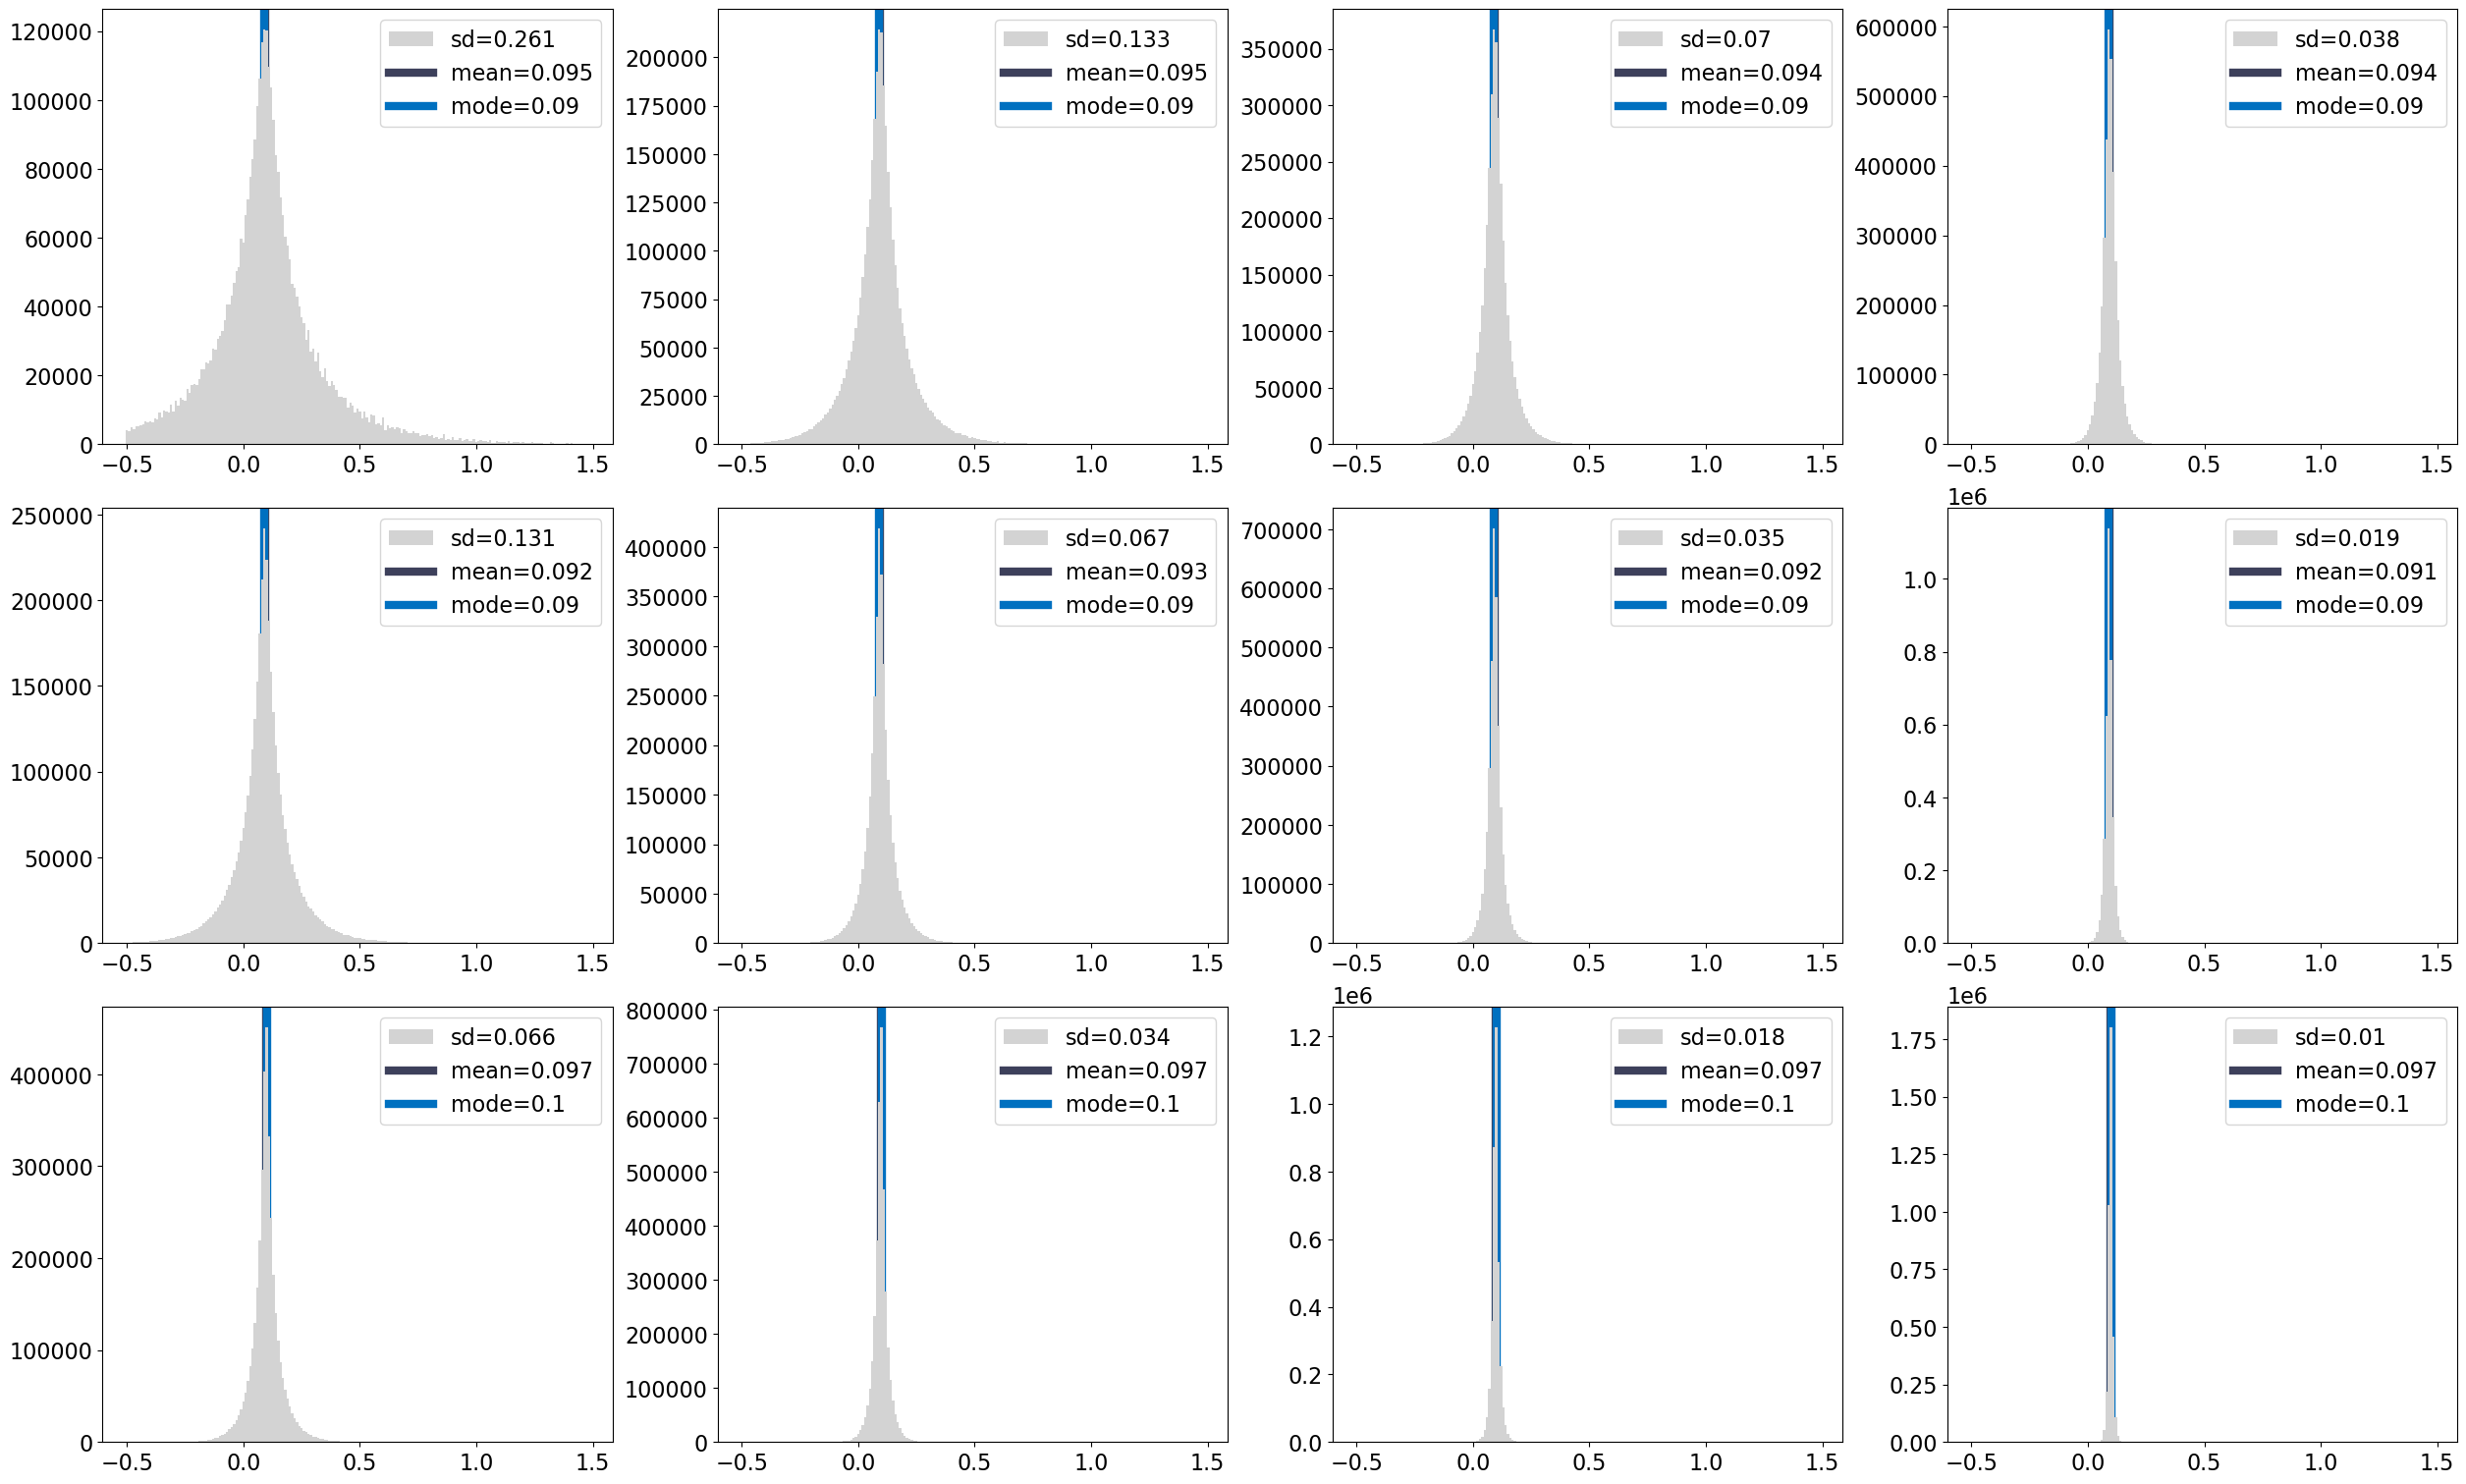

In [10]:
fig,axs = plt.subplots(3,4,figsize=(25,15))

c, X = simulate(s=0.1, n_cells=250, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[0,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=250, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[0,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=250, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[0,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=250, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[0,3],min_mean=0.8)

c, X = simulate(s=0.1, n_cells=1000, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[1,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=1000, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[1,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=1000, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[1,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=1000, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[1,3],min_mean=0.8)

c, X = simulate(s=0.1, n_cells=4000, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[2,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=4000, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[2,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=4000, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[2,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=4000, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_s(N1=X,ax=axs[2,3],min_mean=0.8)

The sd of normalized covariance is $\propto \frac{1}{\sqrt{n}\bar{X}}$

In [11]:
def estimate_eta(N1,  plot=True, ax=None, min_mean=0.1, max_mean=np.inf, 
               bins=np.arange(-0.5, 1.5, 0.01) - 0.005, color='lightgray', modcolor='#0070c0', 
               meancolor='#3d405b'):
    """
    Computes normalized variance.
    """
    ### calculate normalized covariance
    idx = (N1.mean(0) > min_mean) & (N1.mean(0) < max_mean)
    p = idx.sum()
    X = N1[:, idx]
    X_mean = X.mean(0)
    X_var = X.var(0)
    eta = (X_var - X_mean) / X_mean**2        
    
    ### calculate s as the mean
    s = np.mean(eta)

    ### calculate s_mod as the midpoint of the most frequent bin in the histogram.
    if plot is False:
        hist, bins = np.histogram(eta.flatten(), bins=bins)
        s_mod = (bins[np.argmax(hist)] + bins[np.argmax(hist) + 1]) / 2
    else:
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        hist, bins, patches = ax.hist(eta.flatten(), bins=bins, label='sd='+str(np.around(np.std(eta), 3)), color=color)
        s_mod = (bins[np.argmax(hist)] + bins[np.argmax(hist) + 1]) / 2
        ax.axvline(x=s, c=meancolor, zorder=0, linewidth=6, label='mean=' + str(np.around(s, 3)))
        ax.axvline(x=s_mod, c=modcolor, zorder=0, linewidth=6, label='mode=' + str(np.around(s_mod, 3)))
        ax.legend(loc='upper right')
    return {'mod':s_mod,'mean':s}

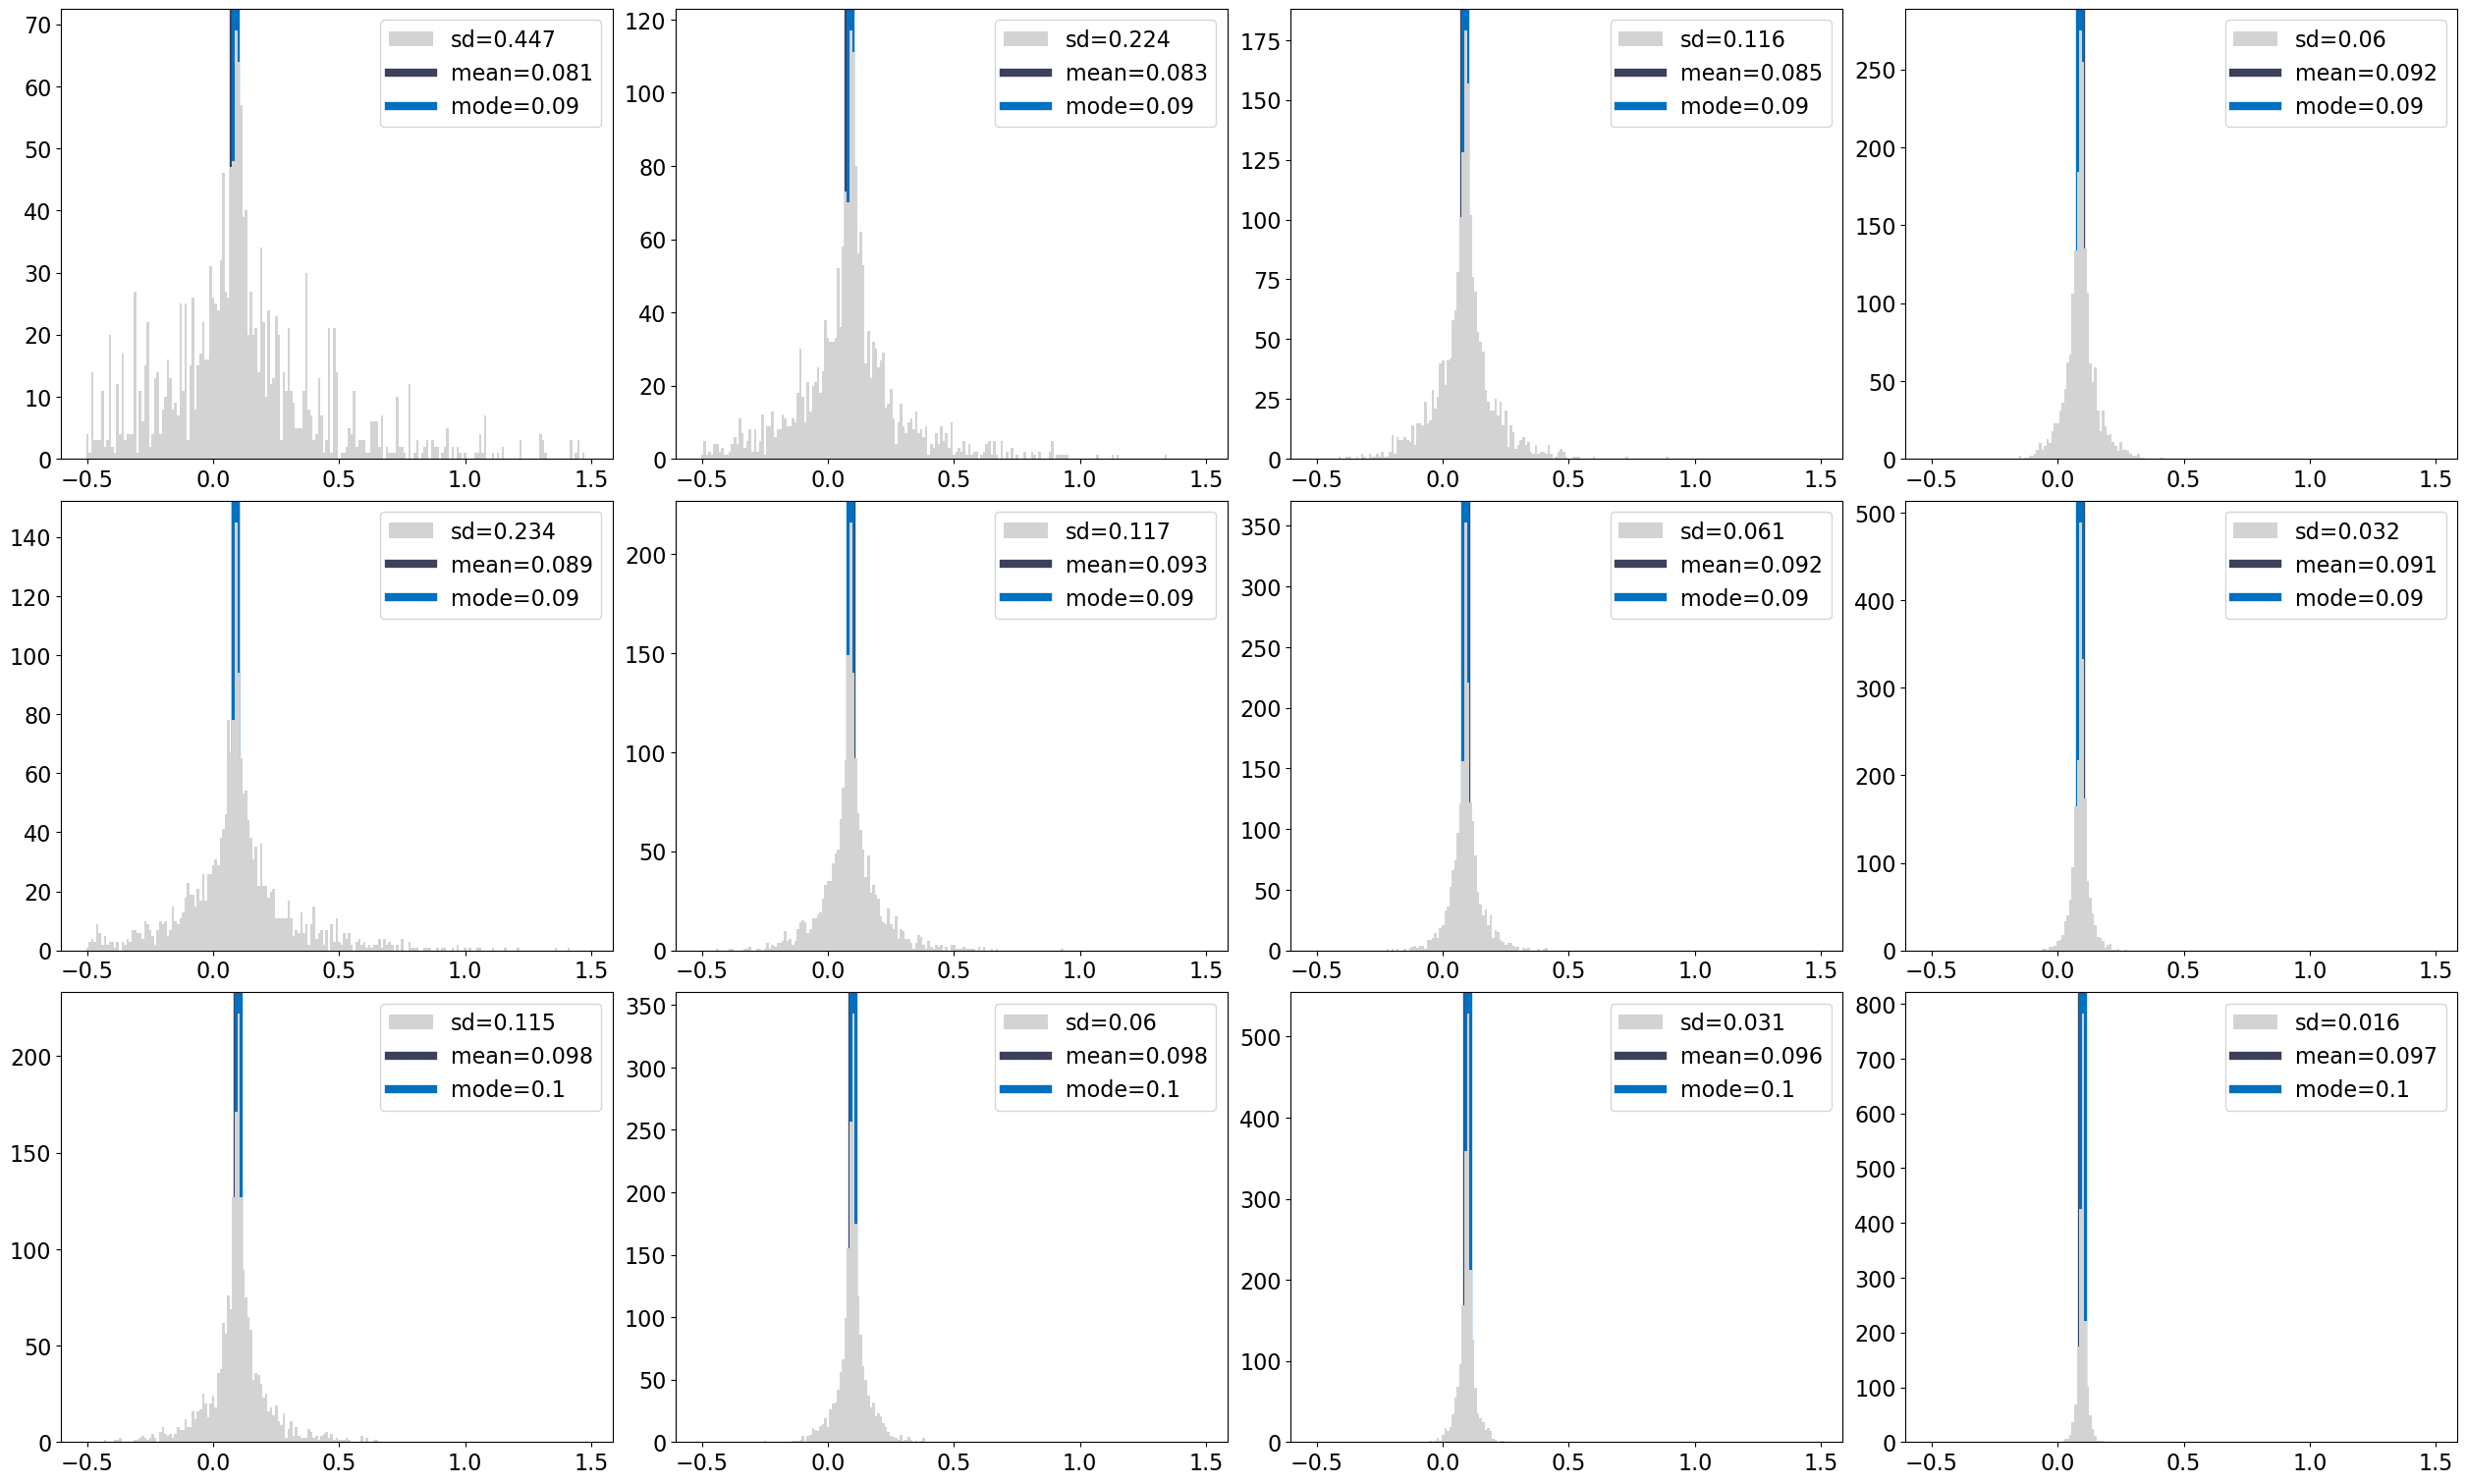

In [12]:
fig,axs = plt.subplots(3,4,figsize=(25,15))

c, X = simulate(s=0.1, n_cells=250, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[0,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=250, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[0,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=250, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[0,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=250, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[0,3],min_mean=0.8)

c, X = simulate(s=0.1, n_cells=1000, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[1,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=1000, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[1,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=1000, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[1,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=1000, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[1,3],min_mean=0.8)

c, X = simulate(s=0.1, n_cells=4000, lam=pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[2,0],min_mean=0.1)
c, X = simulate(s=0.1, n_cells=4000, lam=2*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[2,1],min_mean=0.2)
c, X = simulate(s=0.1, n_cells=4000, lam=4*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[2,2],min_mean=0.4)
c, X = simulate(s=0.1, n_cells=4000, lam=8*pure.layers['mature'].toarray().mean(0))
s_ = estimate_eta(N1=X,ax=axs[2,3],min_mean=0.8)

## Varaince plot

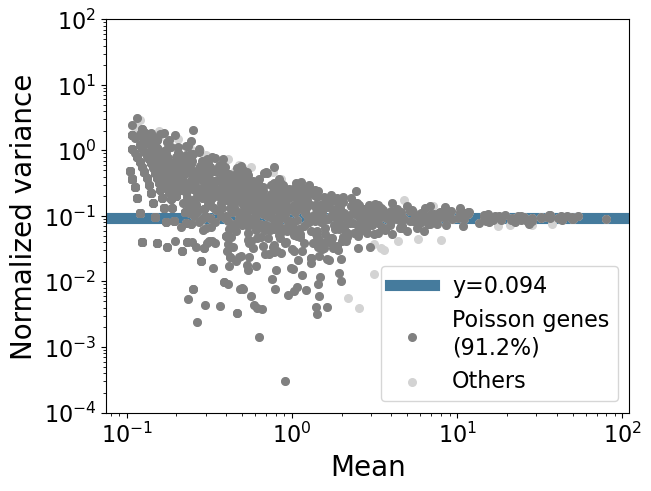

In [15]:
c, X = simulate(s=0.1, n_cells=250, lam=pure.layers['mature'].toarray().mean(0))
s = c.var()/c.mean()**2

nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

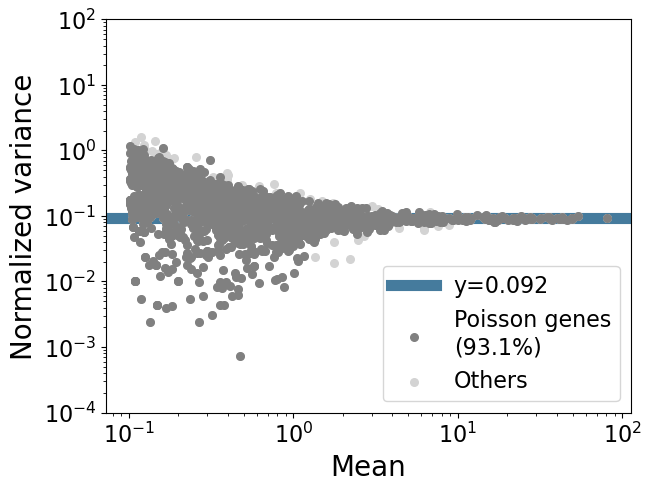

In [20]:
c, X = simulate(s=0.1, n_cells=1000, lam=pure.layers['mature'].toarray().mean(0))
s = c.var()/c.mean()**2

nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

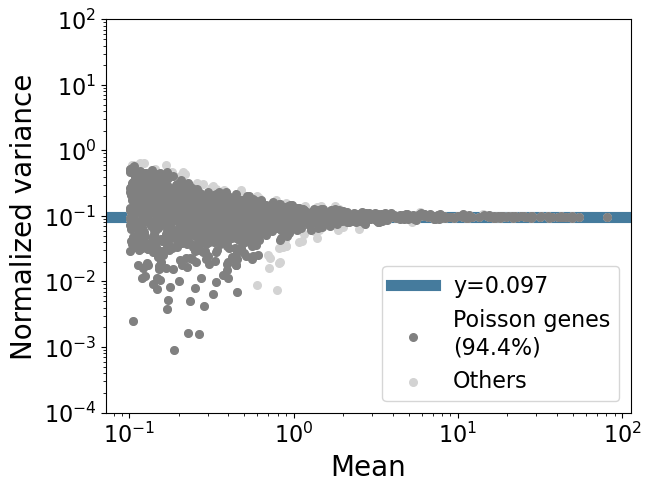

In [18]:
c, X = simulate(s=0.1, n_cells=4000, lam=pure.layers['mature'].toarray().mean(0))
s = c.var()/c.mean()**2

nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(normalized_variance,[X_],B=1000,n_cores=10)
E_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
Pgene_mask = E_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,1e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Normalized variance',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

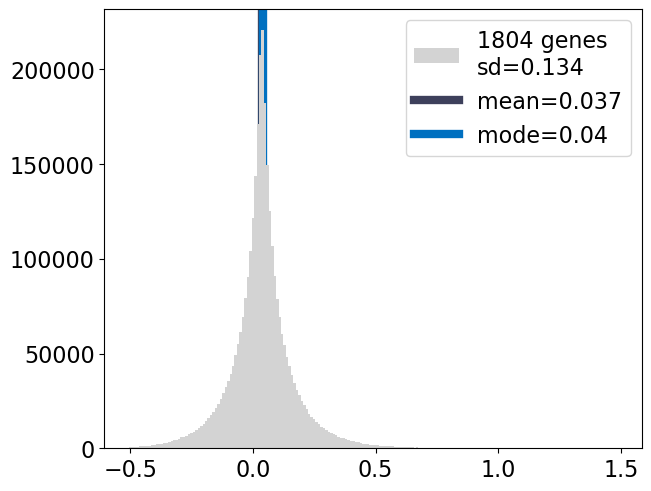

In [169]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

**Check over-dispersed genes**

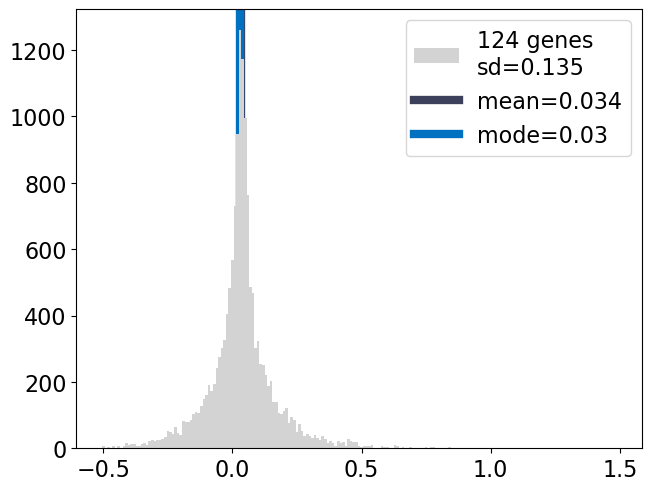

In [170]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,~Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

## Cell size

In [171]:
cellsize_P = X_P.sum(1)
cellsize_X = X.sum(1)

Text(0, 0.5, 'Truth')

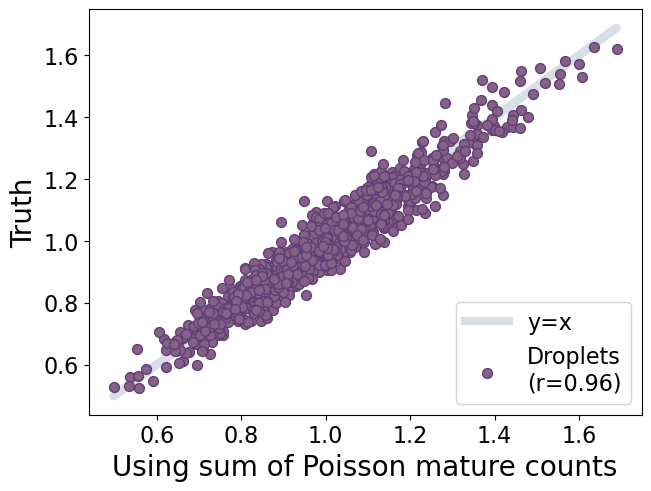

In [173]:
x = cellsize_P/cellsize_P.mean()
y = c

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using sum of Poisson mature counts',fontsize=20)
plt.ylabel('Truth',fontsize=20)

Text(0, 0.5, 'Truth')

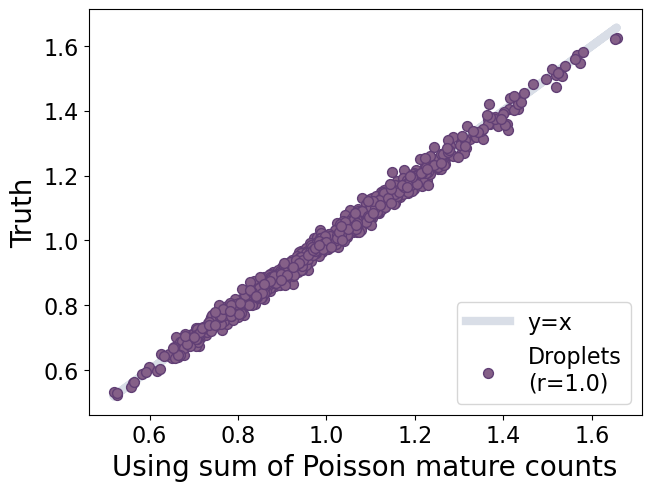

In [176]:
x = cellsize_X/cellsize_X.mean()
y = c

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,color='#856088',edgecolor='#613f75',alpha=1,s=50,\
           label='Droplets\n(r='+str(np.around(np.corrcoef(x,y)[0,1],2))+")")

plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Using sum of Poisson mature counts',fontsize=20)
plt.ylabel('Truth',fontsize=20)

Text(0.5, 0, 'Values')

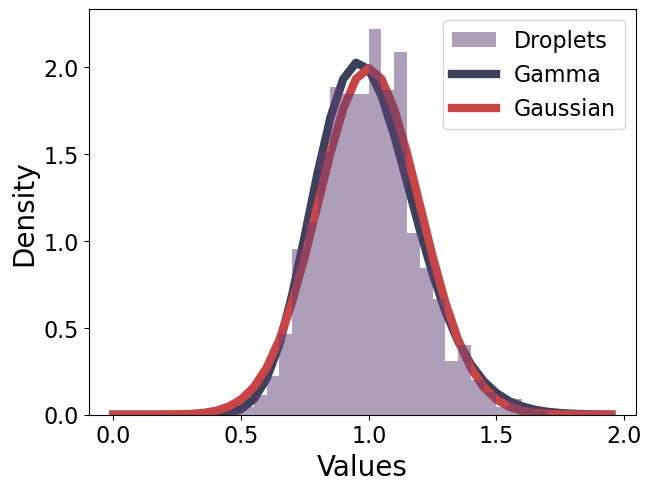

In [175]:
x = np.arange(0,2,0.05)
ds = cellsize_P/cellsize_P.mean()
plt.hist(ds,bins=x,density=True,color='#613f75',alpha=0.5,label='Droplets');
plt.plot(x,gamma.pdf(x,a=1/s,scale=s),c='#3d405b',zorder=0,label='Gamma')
plt.plot(x,norm.pdf(x,loc=1,scale=np.sqrt(s)),c='#c74546',zorder=0,label='Gaussian')
plt.legend(fontsize=16)
plt.ylabel('Density',fontsize=20)
plt.xlabel('Values',fontsize=20)

# Poisson + Poisson

In [10]:
def simulate_(s, n_cells, lam, samp, seed=0):
    np.random.seed(seed)
    c = np.random.gamma(shape=1/s,scale=s,size=n_cells)
    Y = np.random.poisson(lam=c[:,None]*(lam/samp)[None,:])
    X = np.random.poisson(lam=Y*samp)
    return c, X

In [11]:
c, X = simulate_(s=0.4, n_cells=300, lam=pure.layers['nascent'].toarray().mean(0), samp=1)
c.var()/c.mean()**2

0.39899260966269123

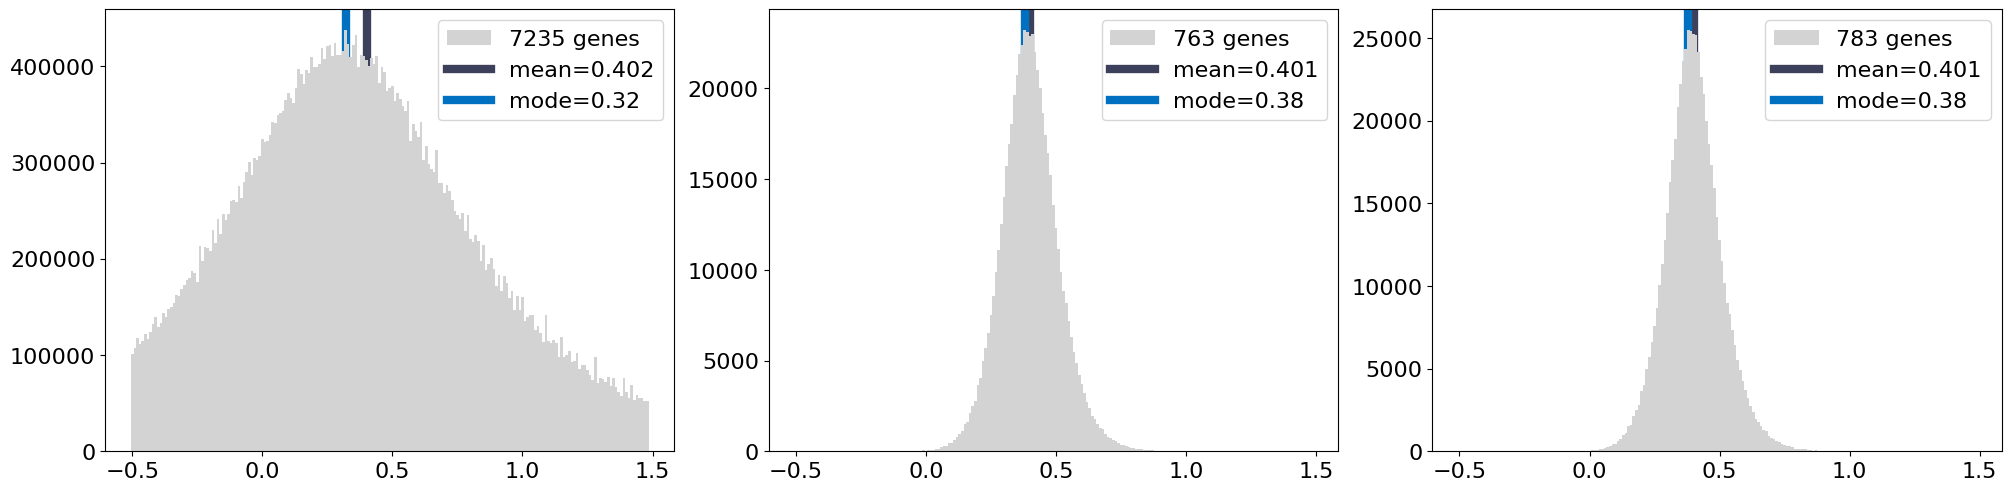

In [12]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_ = estimate_s(N1=X,ax=axs[0],min_mean=0.1,max_mean=1)
s_ = estimate_s(N1=X,ax=axs[1],min_mean=1,max_mean=10)
s_ = estimate_s(N1=X,ax=axs[2],min_mean=1)

100%|██████████| 1000/1000 [00:02<00:00, 459.36it/s]


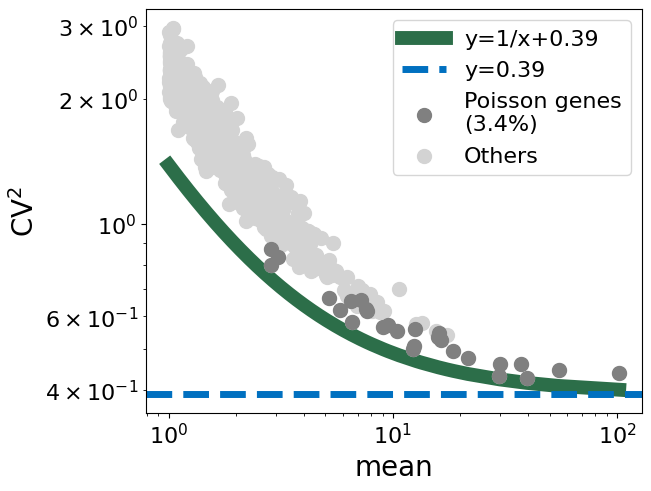

In [13]:
fig,ax = plt.subplots(1,1)

s = 0.39
nonzero_idx = X.mean(0)>1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=10)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

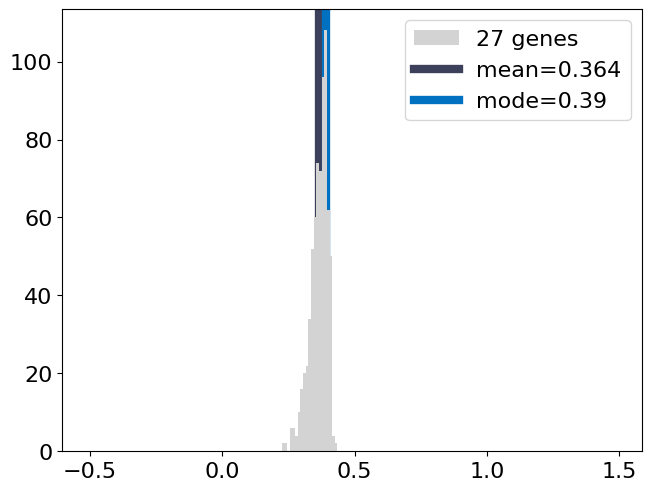

In [14]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

## 1000 cells

In [121]:
c, X = simulate_(s=0.1, n_cells=1000, lam=pure.layers['nascent'].toarray().mean(0), samp=0.5)
c.var()/c.mean()**2

0.09199235441151107

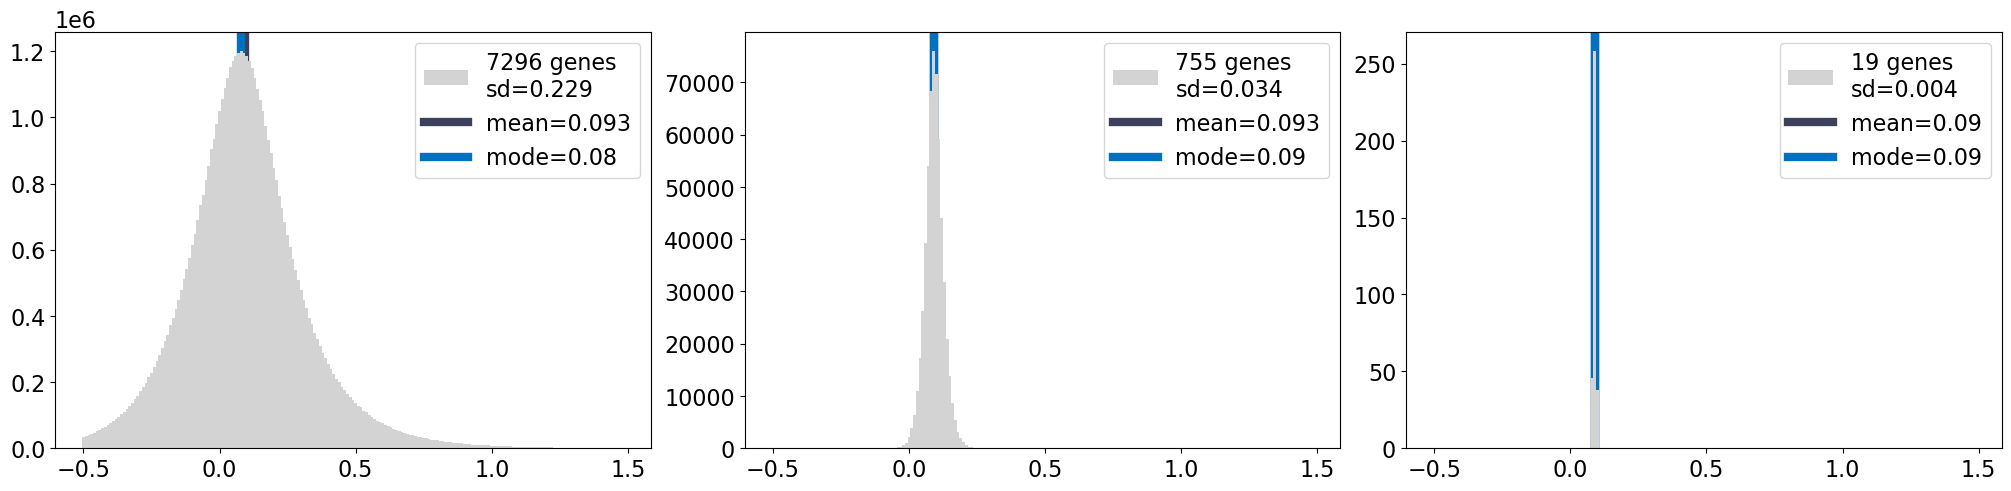

In [122]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_ = estimate_s(N1=X,ax=axs[0],min_mean=0.1,max_mean=1)
s_ = estimate_s(N1=X,ax=axs[1],min_mean=1,max_mean=10)
s_ = estimate_s(N1=X,ax=axs[2],min_mean=10)

/tmp/ipykernel_3088242/964103223.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.scatter(X_mean, s+0.2/X_mean,c='orange',alpha=1, s=10, label='y='+str(np.around(s,2))+'+0.2/x')
/tmp/ipykernel_3088242/964103223.py:7: RuntimeWarning: invalid value encountered in divide
  ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='gray',alpha=1, s=10)


(-10.0, 10.0)

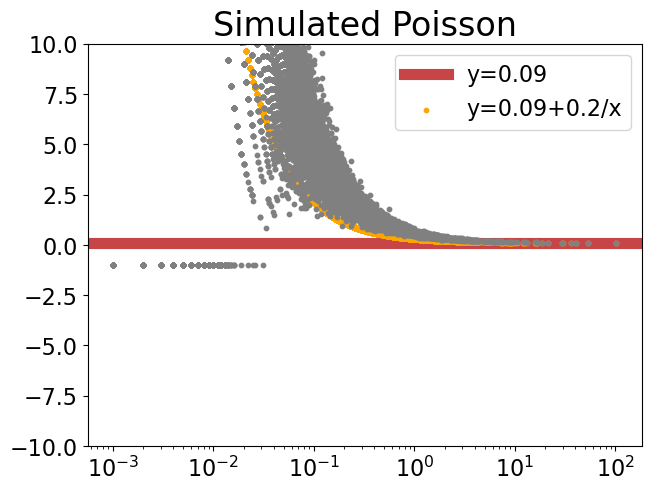

In [123]:
s = 0.09
X_mean, X_var = X.mean(0), X.var(0)

fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(s, color='#c74546', linewidth=8, alpha=1,  zorder=0, label='y='+str(np.around(s,2)))
ax.scatter(X_mean, s+0.2/X_mean,c='orange',alpha=1, s=10, label='y='+str(np.around(s,2))+'+0.2/x')
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='gray',alpha=1, s=10)
ax.set_xscale('log')
ax.set_title('Simulated Poisson',fontsize=title_font)
ax.legend(fontsize=legend_font,loc='upper right')
ax.set_ylim([-10,10])

100%|██████████| 1000/1000 [00:07<00:00, 130.86it/s]


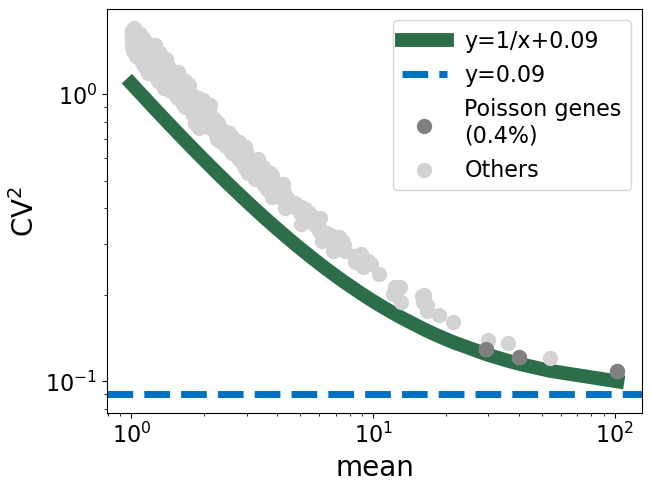

In [124]:
fig,ax = plt.subplots(1,1)

nonzero_idx = X.mean(0)>1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=10)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

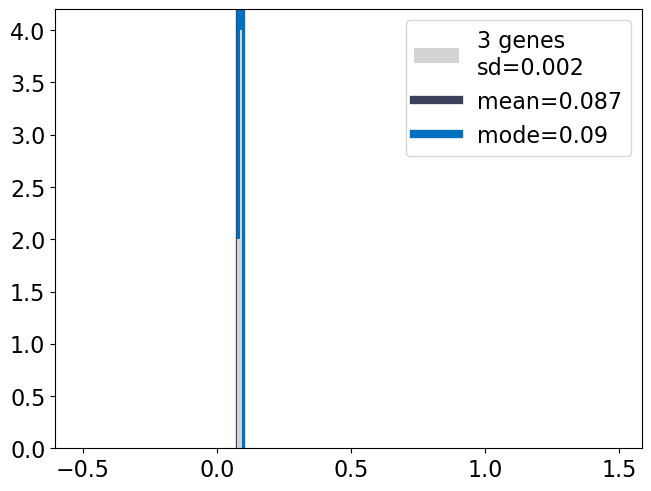

In [125]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

## 10000 cells

In [136]:
c, X = simulate_(s=0.23, n_cells=10000, lam=pure.layers['mature'].toarray().mean(0), samp=0.1)
c.var()/c.mean()**2

0.22661402524555493

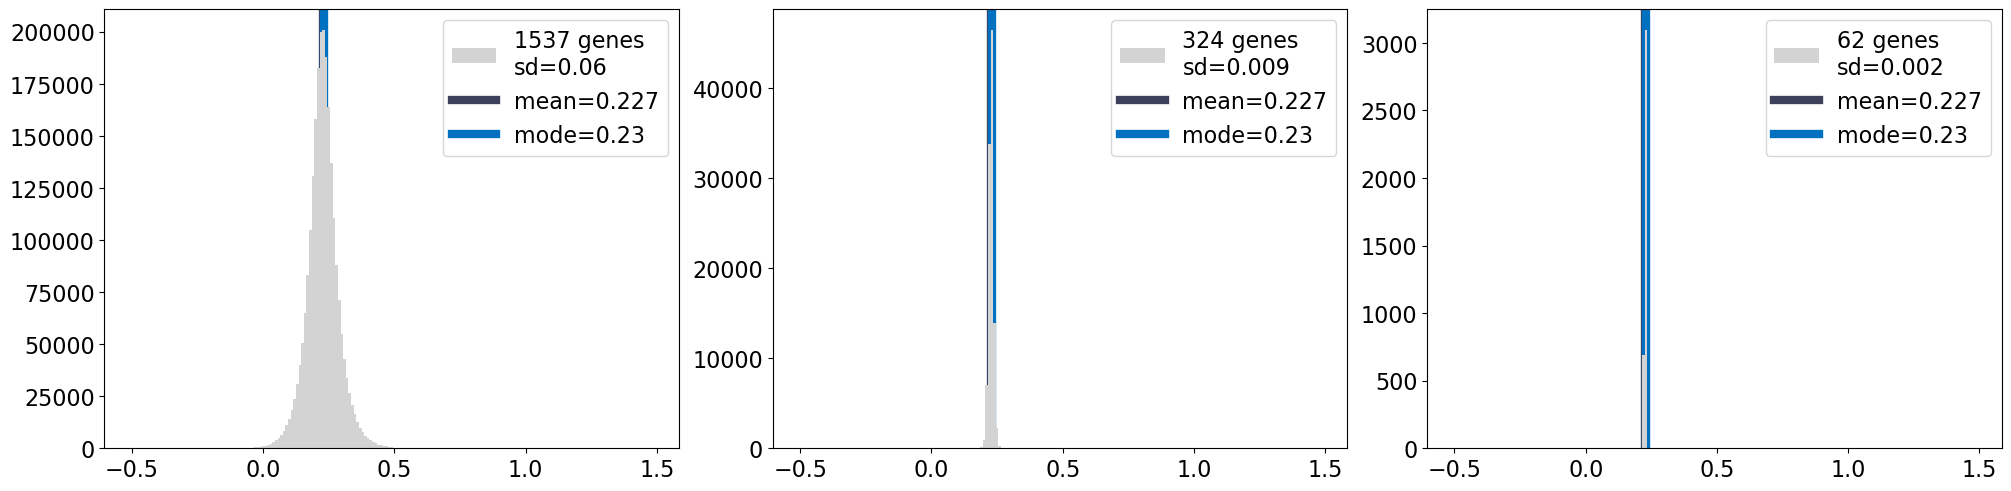

In [137]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_ = estimate_s(N1=X,ax=axs[0],min_mean=0.1,max_mean=1)
s_ = estimate_s(N1=X,ax=axs[1],min_mean=1,max_mean=10)
s_ = estimate_s(N1=X,ax=axs[2],min_mean=10)

/tmp/ipykernel_3088242/3597341763.py:6: RuntimeWarning: divide by zero encountered in divide
  ax.scatter(X_mean, s+0.1/X_mean,c='orange',alpha=1, s=10, label='y='+str(np.around(s,2))+'+0.23/x')
/tmp/ipykernel_3088242/3597341763.py:7: RuntimeWarning: invalid value encountered in divide
  ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='gray',alpha=1, s=10)


(-10.0, 10.0)

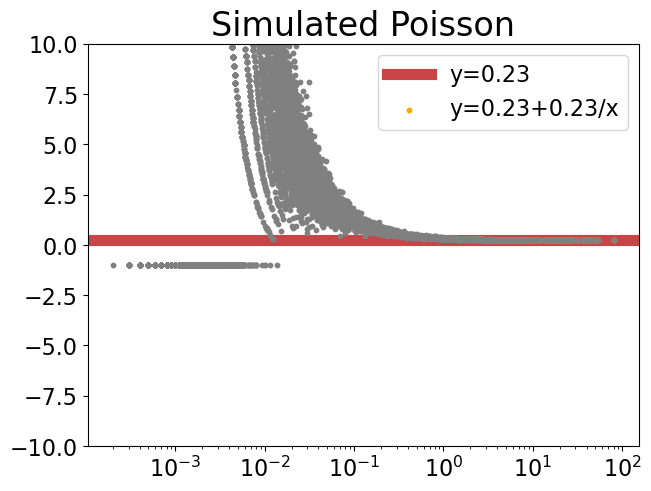

In [140]:
s = 0.23
X_mean, X_var = X.mean(0), X.var(0)

fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(s, color='#c74546', linewidth=8, alpha=1,  zorder=0, label='y='+str(np.around(s,2)))
ax.scatter(X_mean, s+0.1/X_mean,c='orange',alpha=1, s=10, label='y='+str(np.around(s,2))+'+0.23/x')
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='gray',alpha=1, s=10)
ax.set_xscale('log')
ax.set_title('Simulated Poisson',fontsize=title_font)
ax.legend(fontsize=legend_font,loc='upper right')
ax.set_ylim([-10,10])

100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


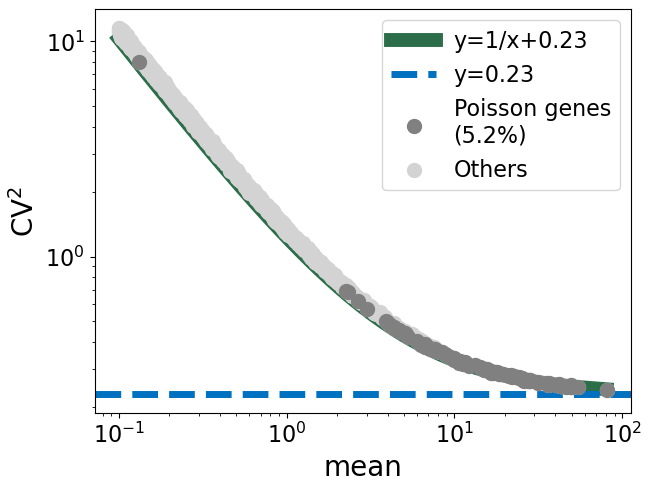

In [141]:
fig,ax = plt.subplots(1,1)

nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=40)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

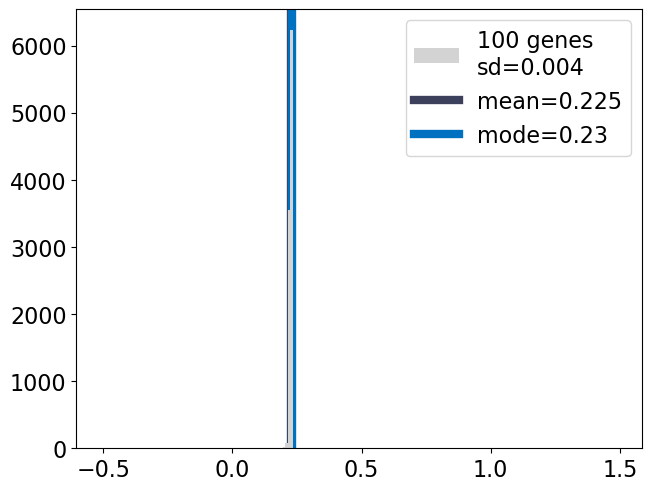

In [142]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

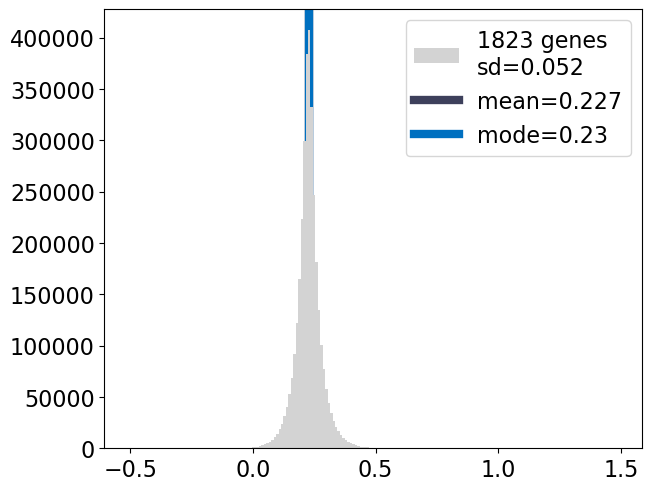

In [144]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,~Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

In [ ]:
nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,eps=0.1,alpha=0.05,B=1000,seed=0,num_cores=10)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

  1%|▏         | 14/1000 [00:04<04:09,  3.96it/s]

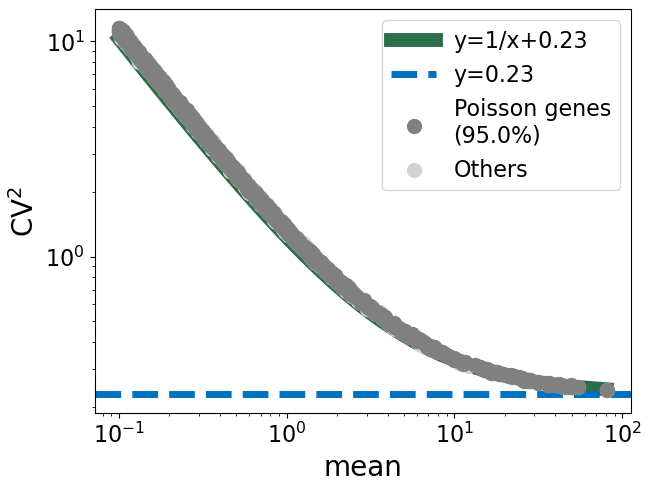

In [148]:
fig,ax = plt.subplots(1,1)

ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

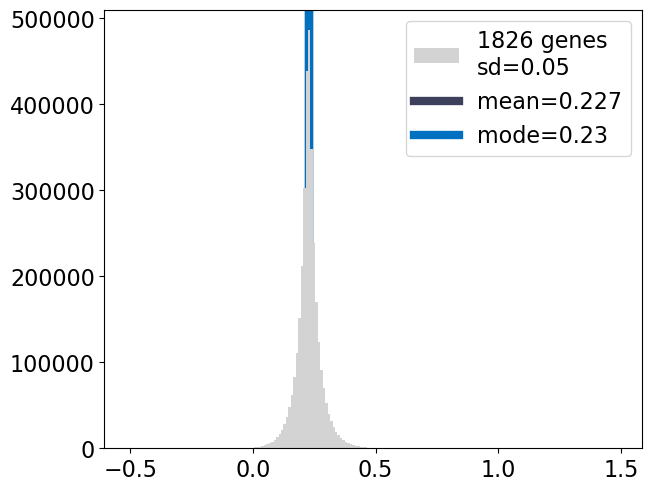

In [147]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

In [177]:
c, X = simulate_(s=0.23, n_cells=10000, lam=pure.layers['mature'].toarray().mean(0), samp=0.05)
c.var()/c.mean()**2

0.22661402524555493

100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


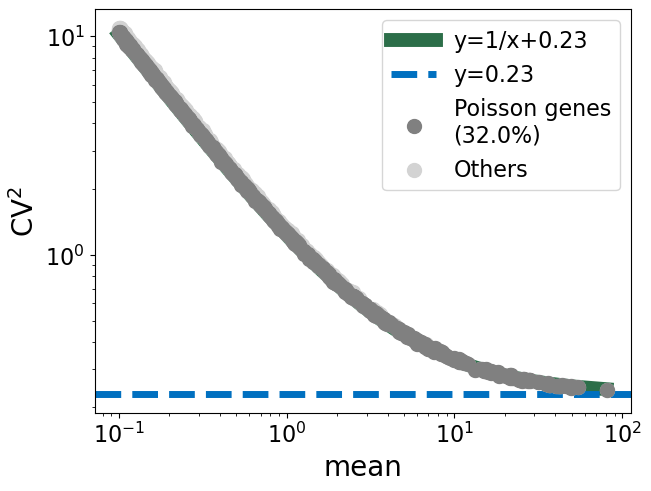

In [178]:
s = 0.23
nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=40)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

fig,ax = plt.subplots(1,1)
ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

In [179]:
c, X = simulate_(s=0.23, n_cells=10000, lam=pure.layers['mature'].toarray().mean(0), samp=0.5)
c.var()/c.mean()**2

0.22661402524555493

100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]


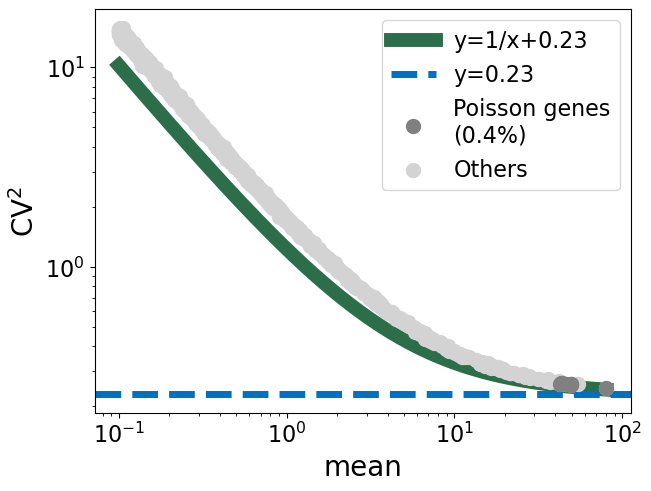

In [180]:
s = 0.23
nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=40)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

fig,ax = plt.subplots(1,1)
ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

# NB + Poisson

In [287]:
def simulate_nb(s, n_cells, lam, samp, seed=0):
    np.random.seed(seed)
    c = np.random.gamma(shape=1/s,scale=s,size=n_cells)
    Y = np.random.negative_binomial(n=c[:,None]*(lam/samp)[None,:],p=np.random.uniform(0,0.5,size=len(lam))[None,:])
    X = np.random.poisson(lam=Y*samp)
    return c, X

In [288]:
c, X = simulate_nb(s=0.2, n_cells=1000, lam=pure.layers['mature'].toarray().mean(0)[pure.layers['mature'].toarray().mean(0)>0], samp=0.1)
c.var()/c.mean()**2

0.18599722227660687

In [289]:
c.mean()

0.99223842972755

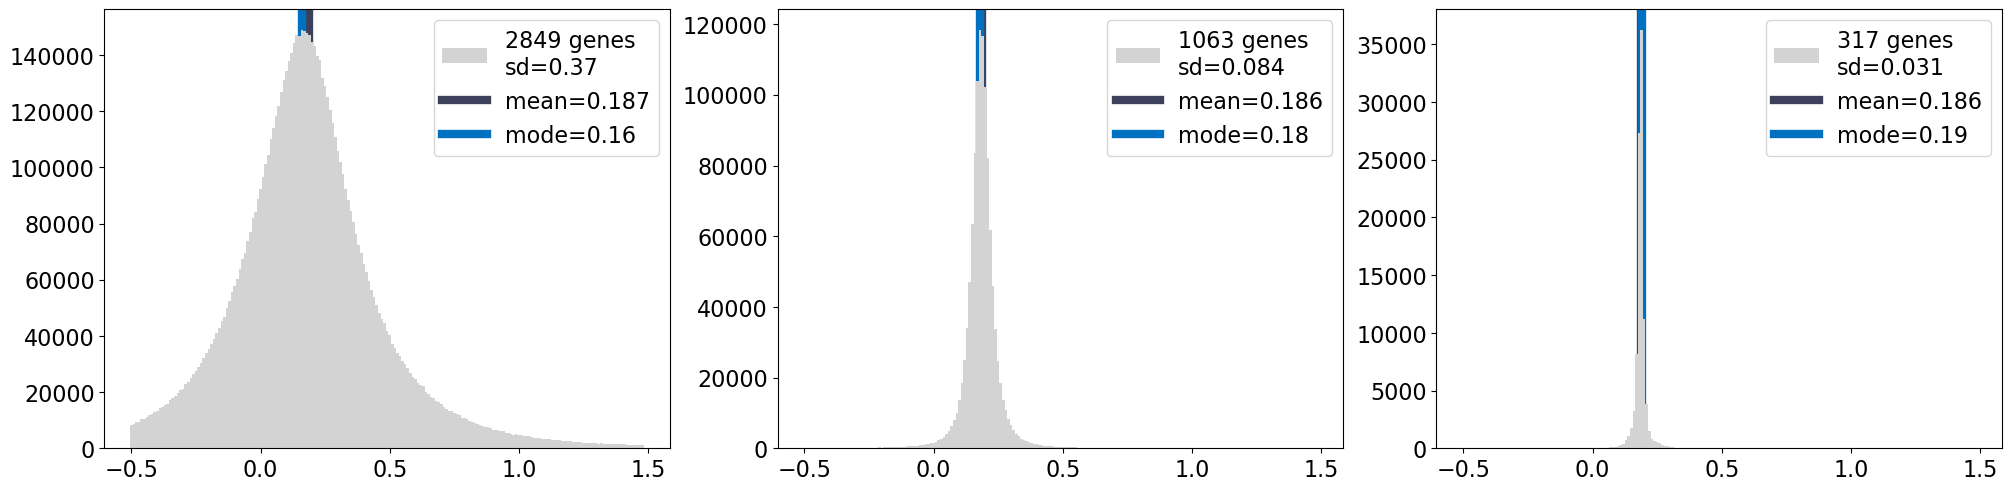

In [290]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_ = estimate_s(N1=X,ax=axs[0],min_mean=0.1,max_mean=1)
s_ = estimate_s(N1=X,ax=axs[1],min_mean=1,max_mean=10)
s_ = estimate_s(N1=X,ax=axs[2],min_mean=10)

100%|██████████| 1000/1000 [01:22<00:00, 12.19it/s]


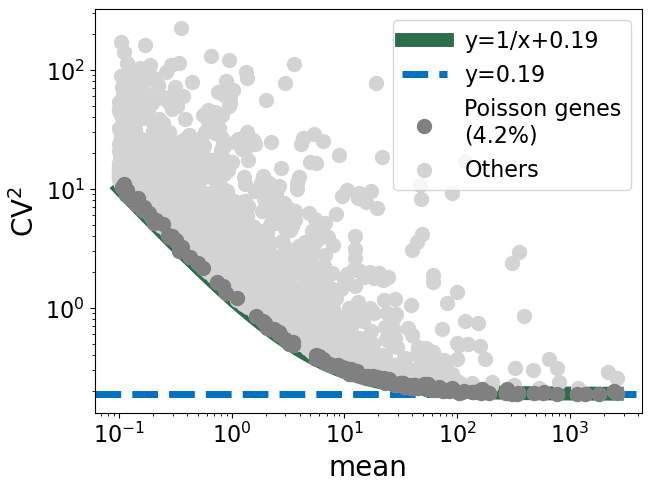

In [291]:
s = 0.19

fig,ax = plt.subplots(1,1)

nonzero_idx = X.mean(0)>0.1
X_ = X[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)

lower_bound, upper_bound, bootstrap_se = bootstrapping_var(X_,alpha=0.05,B=1000,seed=0,num_cores=50)
Pgene_mask = (s < upper_bound) & (s > lower_bound) 

ax.plot(np.sort(X_mean), 1/np.sort(X_mean) + s, color='#2c6e49', linewidth=10, zorder=0, label='y=1/x+'+str(np.around(s,2)))
ax.axhline(y=s, linestyle='--', color='#0070c0', linewidth=5, zorder=0, label="y="+str(np.around(s,2)))
ax.scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=100, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=100, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean',fontsize=20)
ax.set_ylabel(r'CV$^2$',fontsize=20)
ax.legend(loc='upper right',fontsize=16);

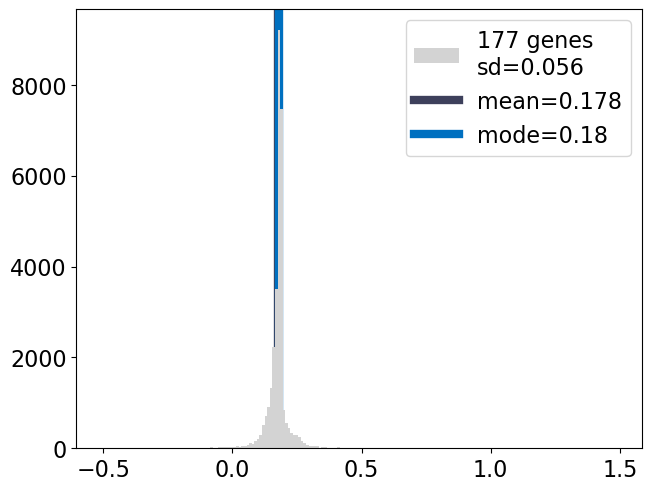

In [294]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

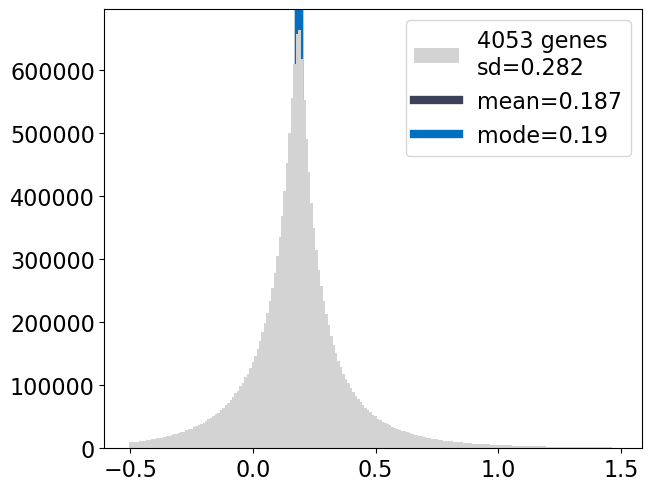

In [295]:
fig,axs = plt.subplots(1,1)

X_P = X[:,nonzero_idx][:,~Pgene_mask]
s_ = estimate_s(X_P,ax=axs)

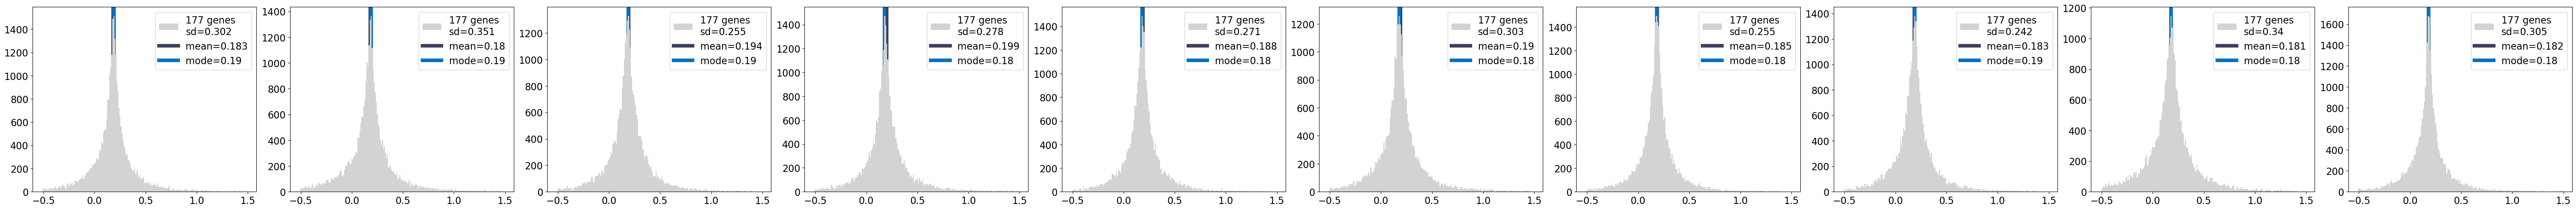

In [300]:
fig,axs = plt.subplots(1,10,figsize=(60,4.8))
B = 10

n,p = X_.shape
s_bootrapping_genes = []

np.random.seed(2025)
for b in range(B):
    idx = np.random.choice(p,Pgene_mask.sum(),replace=False)
    data = X_[:,idx]
    s_bootrapping_genes.append(estimate_s(N1=data,ax=axs[b],min_mean=0.1))